# Multi-Wavelength Beam Shaping: RGB Smiley Generation

This tutorial demonstrates chromatic beam shaping using a cascade of diffractive
optical elements (DOEs). We optimize four DOEs to transform three Gaussian beams
(red, green, blue) into a color smiley face pattern: red head, green eyes, blue mouth.

## Chromatic DOE Design

Each DOE introduces wavelength-dependent phase shifts through height modulation.
By cascading multiple DOEs with propagation between them, we can independently
control the spatial distribution of each wavelength, enabling complex multi-color
beam shaping.

In [1]:
using FluxOptics, Zygote, CairoMakie
using CUDA  # Comment if you don't have CUDA

## Target Images

We load three grayscale target patterns that define the desired intensity
distribution for each color channel. The images are padded to avoid edge effects
during propagation and normalized to unit power.

In [2]:
using Images

data = "data"

function pad_0(u, n)
    nx, ny = size(u)
    A = zeros(eltype(u), (nx + 2*n, ny + 2*n))
    A[(n + 1):(n + nx), (n + 1):(n + ny)] .= u
    A
end

n_pad = 100;

Load and normalize target patterns

In [3]:
I_head = pad_0(Float32.(load("$(data)/smiley_600x600_head.png")[end:-1:1, 1:end]'), n_pad)
I_head .-= minimum(I_head)
I_head ./= sum(I_head)

I_mouth = pad_0(Float32.(load("$(data)/smiley_600x600_mouth.png")[end:-1:1, 1:end]'), n_pad)
I_mouth .-= minimum(I_mouth)
I_mouth ./= sum(I_mouth)

I_eyes = pad_0(Float32.(load("$(data)/smiley_600x600_eyes.png")[end:-1:1, 1:end]'), n_pad)
I_eyes .-= minimum(I_eyes)
I_eyes ./= sum(I_eyes);

Composite target (grayscale visualization)

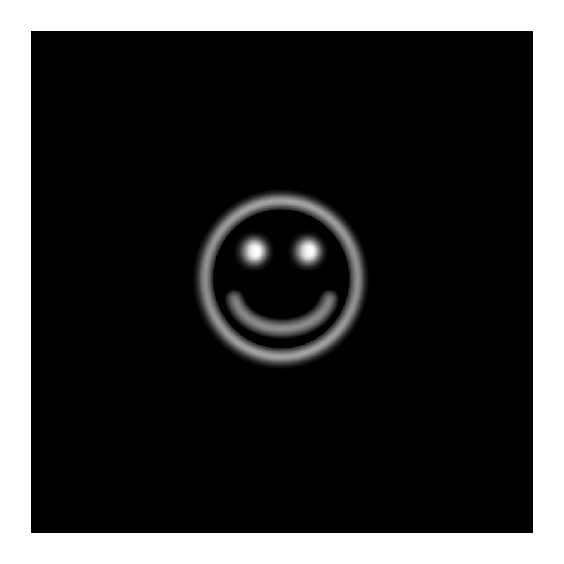

In [4]:
visualize(4*I_head .+ I_eyes .+ I_mouth, identity; colormap=:grayC, height=250)

## Multi-Wavelength Source

We create a multi-wavelength field with three Gaussian beams at blue (455nm),
green (538nm), and red (640nm). The wavelength-dependent refractive index
of the DOE material (n ≈ 1.51) enables chromatic control.

In [5]:
ns = size(I_head)
ds = (0.5, 0.5)
x_vec, y_vec = spatial_vectors(ns, ds)

λ_455 = 0.455  # Blue
λ_538 = 0.538  # Green
λ_640 = 0.640;  # Red

Refractive index dispersion (typical optical glass)

In [6]:
function dn(λ::T) where {T}
    return if λ == T(0.455)
        T(1.518 - 1)
    elseif λ == T(0.538)
        T(1.512 - 1)
    elseif λ == T(0.640)
        T(1.508 - 1)
    else
        T(NaN)
    end
end

lambdas = [λ_640, λ_538, λ_455]

w0_640 = 40.0
w0_538 = 40.0
w0_455 = 40.0;

Create multi-wavelength field

In [7]:
u0 = ScalarField((ns..., 3), ds, lambdas)
u0[:, :, 1] .= 2*Gaussian(w0_640)(x_vec, y_vec)  # Red (2× power)
u0[:, :, 2] .= Gaussian(w0_538)(x_vec, y_vec)    # Green
u0[:, :, 3] .= Gaussian(w0_455)(x_vec, y_vec);    # Blue

Combined target intensity (RGB channels)

In [8]:
If = cat(4*I_head, I_eyes, I_mouth, dims = 3)

u0 = cu(u0)  # Comment if you don't have CUDA
If = cu(If);  # Comment if you don't have CUDA

Visualize initial beams and targets

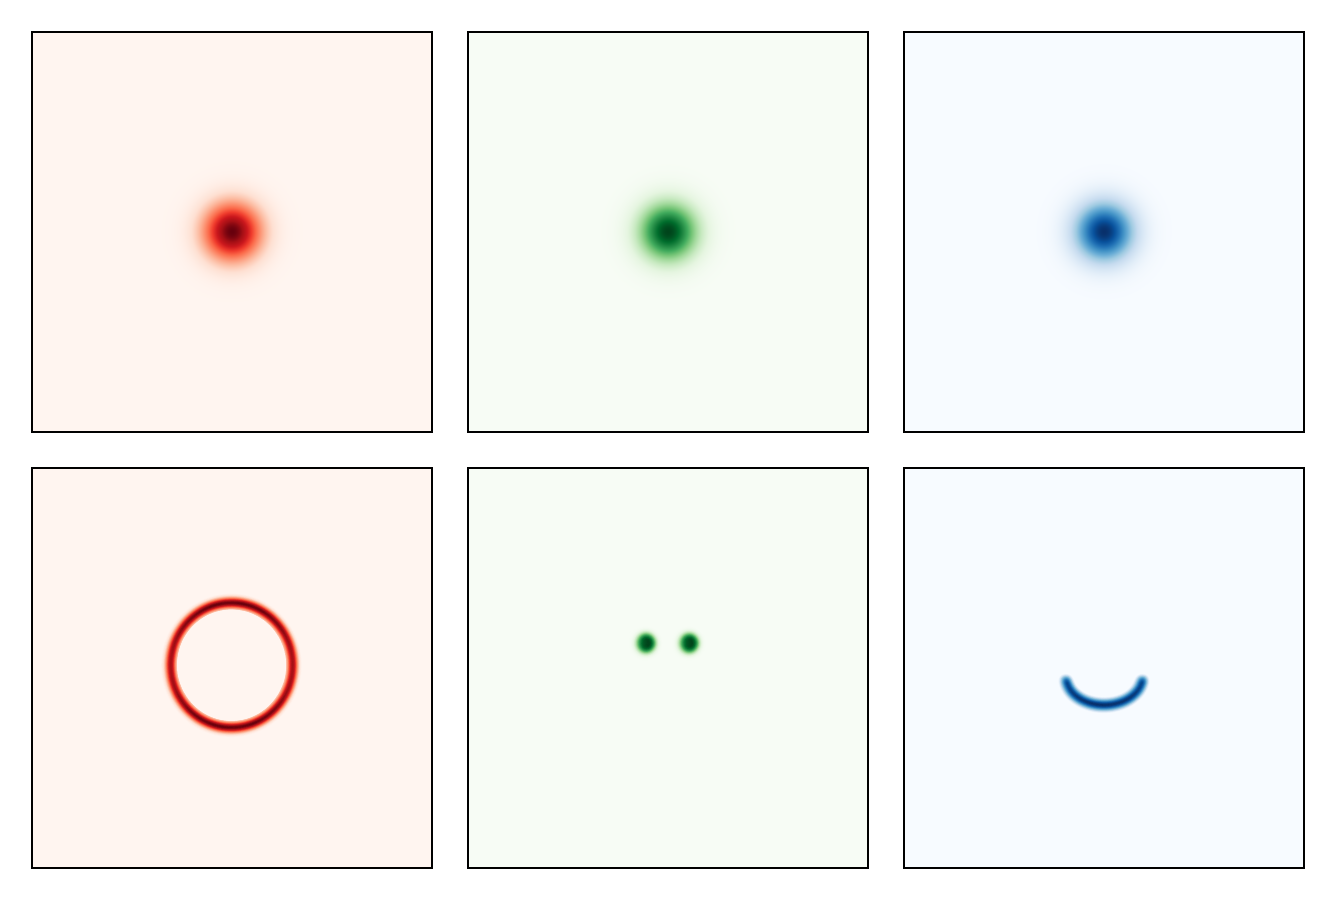

In [9]:
visualize((vec(u0), vec(sqrt.(If), 2)), intensity; colormap=((:Reds, :Greens, :Blues),), height=200)

## Optical System: DOE Cascade

The system consists of four trainable DOEs separated by 3mm free-space propagation.
Each DOE applies wavelength-dependent phase shifts through height modulation. The
optimization will find the height profiles that transform the input Gaussians into
the target smiley pattern.

In [10]:
z = 3000.0  # 3mm propagation between DOEs

p = RSProp(u0, z; use_cache = true)
doe() = TeaDOE(u0, dn; trainable = true, buffered = true)

s = ScalarSource(u0)
system = s |> p |> doe() |> p |> doe() |> p |> doe() |> p |> doe() |> p |>
         (; inplace = true);

## Loss Function and Optimization

We minimize the squared intensity difference between the output and target patterns
across all three wavelengths. The DOE heights are constrained to [-0.5, 0.5] μm to
maintain reasonable fabrication requirements.

In [11]:
intensity_diff = SquaredIntensityDifference((u0, If))
f_opt = m -> sum(intensity_diff(m().out));

Initialize DOEs to zero height

In [12]:
masks = filter(x -> isa(x, TeaDOE), get_components(system))
for mask in masks
    fill!(mask, 0)
end

FISTA with height clamping

In [13]:
rule = Fista(200)
prox = ClampProx(-0.5, 0.5)
opt = FluxOptics.setup(ProxRule(rule, prox), system)

_, g = Zygote.withgradient(f_opt, system);  # Warm-up
FluxOptics.update!(opt, system, g[1]);  # Warm-up

## Optimization Loop

We run 200 iterations of FISTA. The optimization simultaneously shapes all three
wavelengths, finding DOE height profiles that satisfy the chromatic constraints.

In [14]:
losses = Float64[]

@time for i in 1:200
    val, grads = Zygote.withgradient(f_opt, system)
    FluxOptics.update!(opt, system, grads[1])
    push!(losses, val)
end

  6.141115 seconds (2.53 M allocations: 130.089 MiB, 0.97% gc time)


Convergence curve shows steady decrease in loss as the DOEs learn to shape
the multi-wavelength beam into the target smiley pattern.

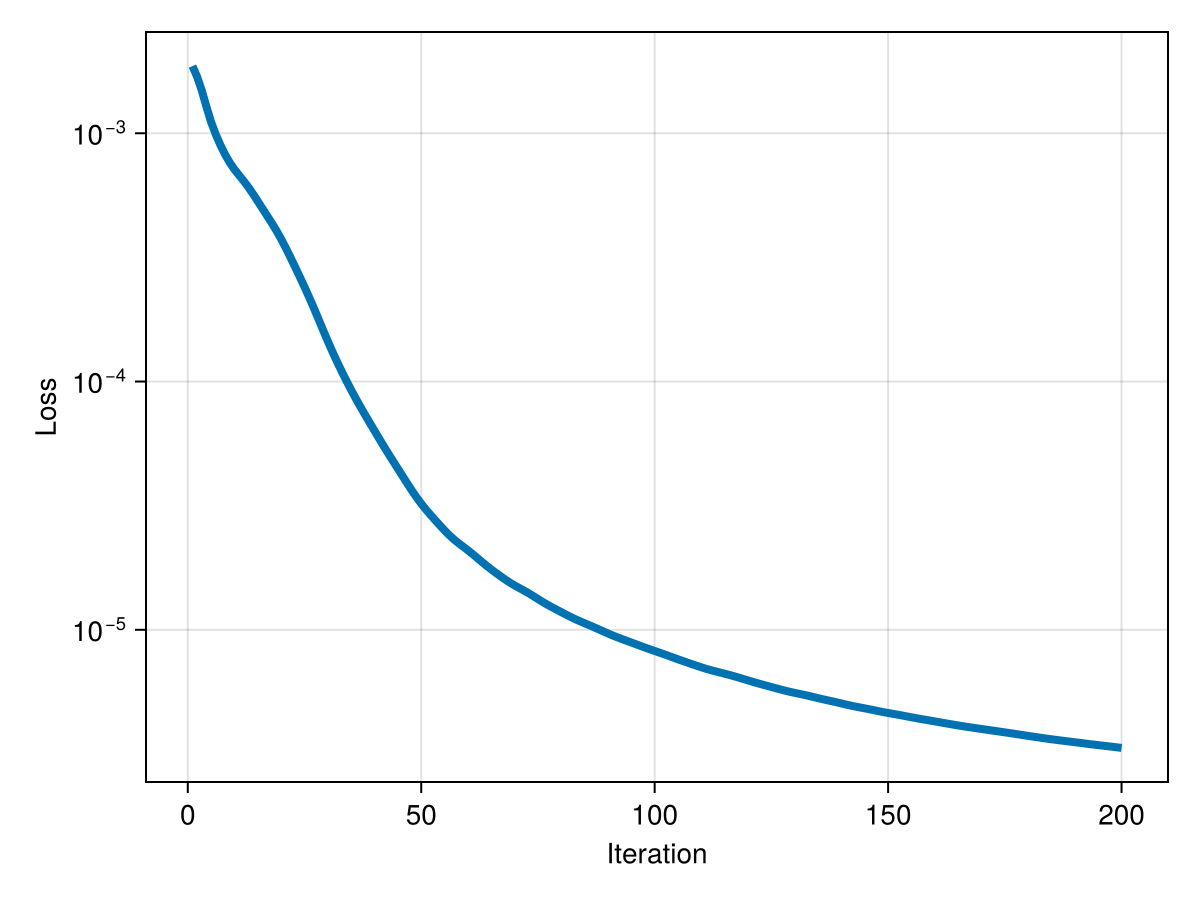

In [15]:
fig_loss = Figure()
ax = Makie.Axis(fig_loss[1, 1], yscale = log10, xlabel = "Iteration", ylabel = "Loss")
lines!(ax, losses; linewidth = 4)
fig_loss

## Optimized DOE Height Profiles

The four optimized DOEs show complex height profiles that enable independent
control of each wavelength. The height structures differ between DOEs as each
contributes to the cumulative transformation through the cascade.

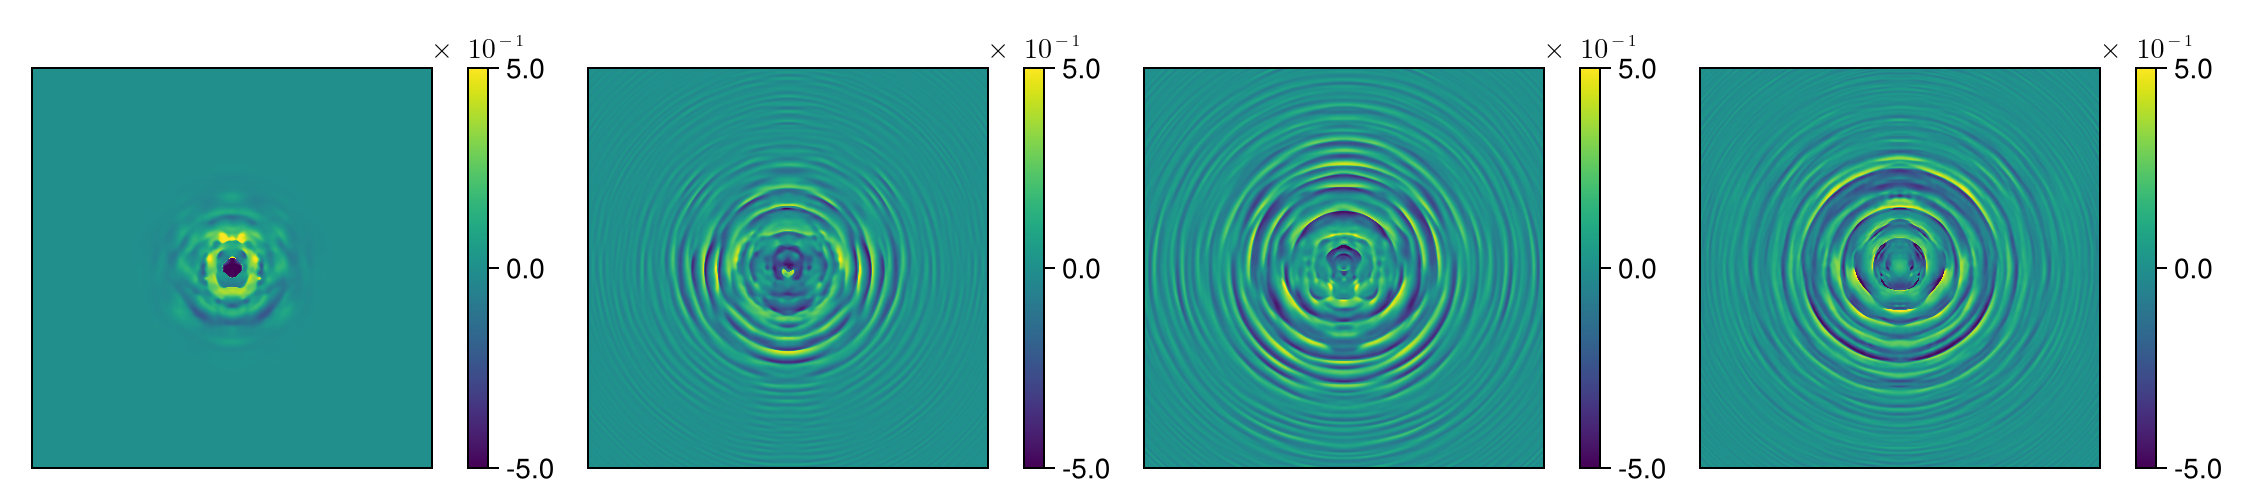

In [16]:
visualize((masks,), identity; show_colorbars=true, height=200)

## Result: RGB Smiley

The final output shows successful chromatic beam shaping. Each wavelength
forms its target pattern: red forms the head, green forms the eyes, and
blue forms the mouth. The color separation demonstrates precise wavelength-
dependent control achieved through the optimized DOE cascade.

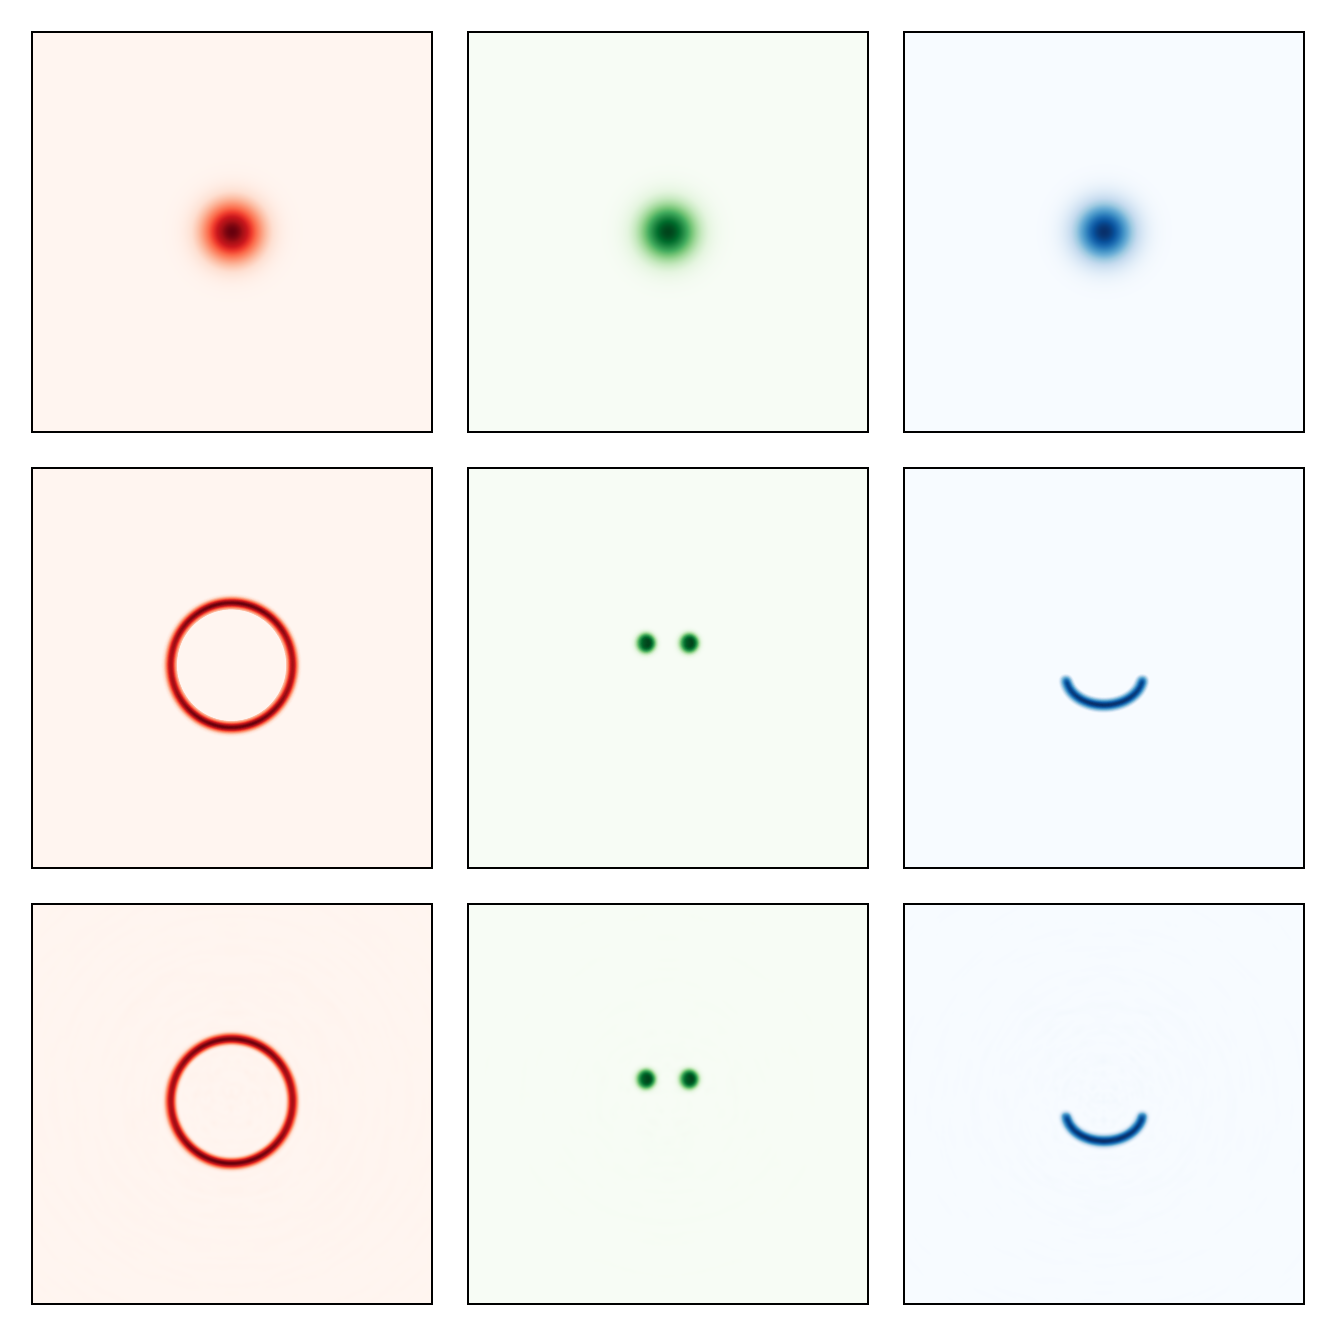

In [17]:
uf = system().out

visualize((vec(u0), vec(sqrt.(If), 2), vec(uf)), intensity; colormap=((:Reds, :Greens, :Blues),), height=200)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*